In [5]:
import numpy as np
import matplotlib.pyplot as plt
from functions import ProcessSpectra, BinSpec, split, get_classification, dered, get_spec_matches, target_wavelength_range
from glob import glob
from joblib import dump, load

In [6]:
# Load the model
model_location = './models/Gr13_KNNClassification_model.k=100.joblib'
clf = load(model_location) 

# load the class list for this model
classlist = np.loadtxt('./PCA_ready/classlist.Gr13.txt',dtype='str')
classlist.sort()

# set the list of the spectra for the templates
ref_sne = glob('./spectra/*')
ref_location = './spectra/'

In [9]:
specname = 'tns_2021auy_2021-01-20_02-12-47_ESO-NTT_EFOSC2-NTT_ePESSTO+.asci'

spectrum = f'./for_classification/{specname}'


In [10]:
best_match, indices, scores = get_classification(spectrum, clf)


pred from pipeline = ['0.052_Ia_SN2011fe_-13.92_.txt']


In [11]:
best_match_properties = split(best_match)
best_match_properties

[('Ia', 'SN2011fe', 0.052, -13.92, 'Ia_SN2011fe_-13.92_.txt')]

## Try with the scores, these are not uniform now the distance is used

In [12]:
sorted_scores, sorted_idxs = zip(*list(sorted(zip(scores,indices), reverse=True)))

redshift = False


a  = get_spec_matches(idxs = sorted_idxs, z = redshift, classlist = classlist )
types, sne, zs, epochs, all_specs = zip(*a)

In [13]:
all_specs[:15]

('Ia_SN2011fe_-13.92_.txt',
 'Ia_SN2011fe_-13.92_.txt',
 'Ia_SN2011fe_-13.92_.txt',
 'Ia_SN2011fe_-13.92_.txt',
 'Ia_SN2011fe_-14.82_.txt',
 'Ia_SN2011fe_-14.82_.txt',
 'Ia_SN2011fe_-13.92_.txt',
 'Ia_SN2011fe_-14.82_.txt',
 'Ia_SN2011fe_-14.82_.txt',
 'Ia_SN2011fe_-13.92_.txt',
 'Ia_SN2011fe_-12.92_.txt',
 'Ia_SN2011fe_-12.92_.txt',
 'Ia_SN2011fe_-14.82_.txt',
 'Ia_SN2011fe_-12.92_.txt',
 'Ia_SN2011fe_-13.92_.txt')

Text(0, 0.5, 'Redshift')

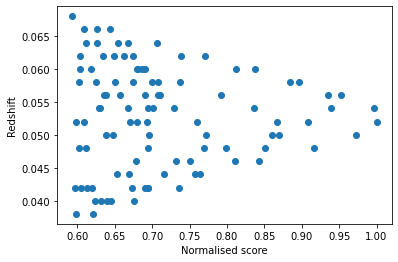

In [14]:
plt.scatter(sorted_scores / max(sorted_scores), zs)
plt.xlabel('Normalised score')
plt.ylabel('Redshift')

Text(0, 0.5, 'Epoch [days]')

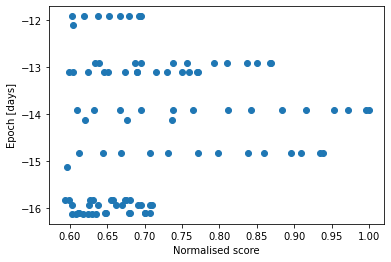

In [15]:
plt.scatter(sorted_scores / max(sorted_scores), epochs)
plt.xlabel('Normalised score')
plt.ylabel('Epoch [days]')

In [16]:
#plt.hist(zs)
#plt.hist(epochs)

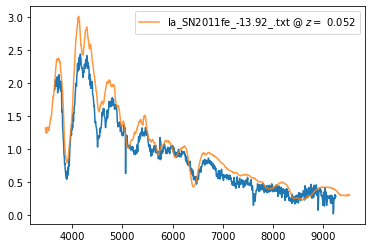

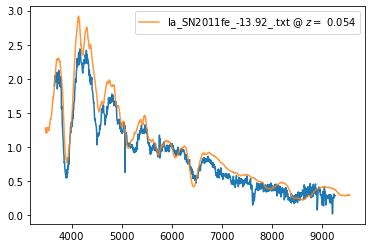

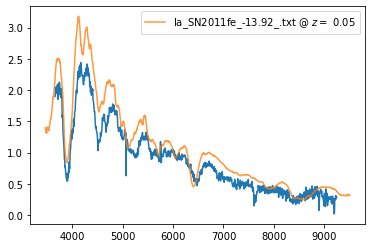

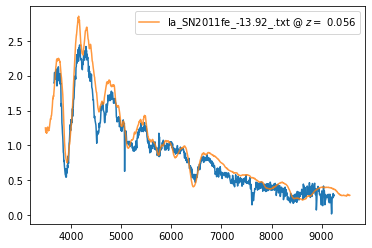

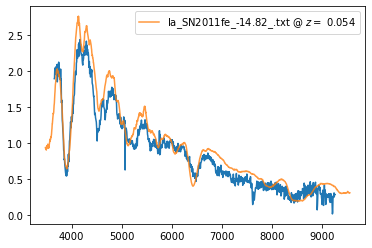

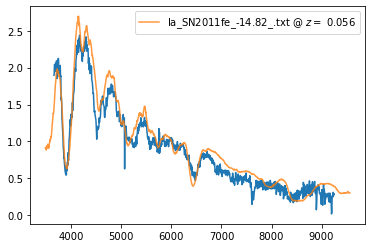

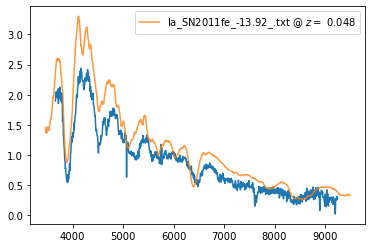

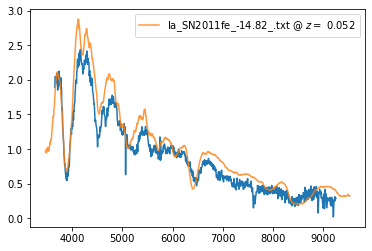

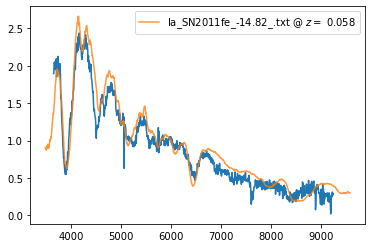

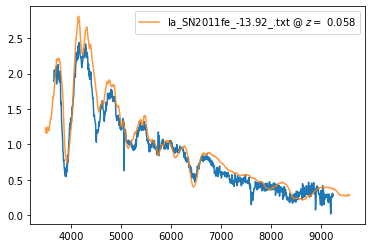

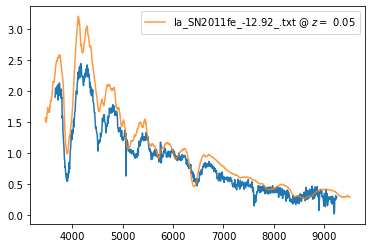

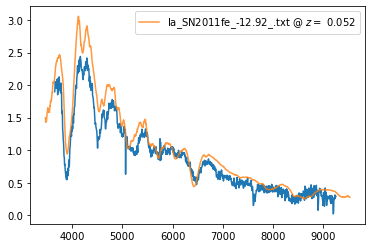

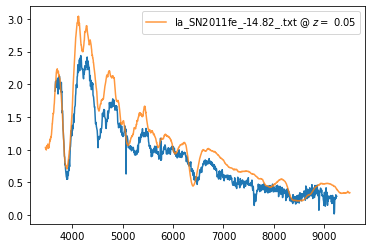

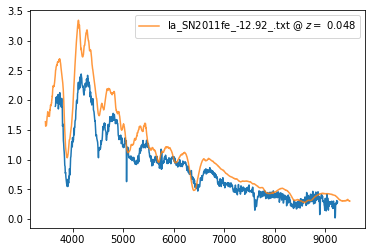

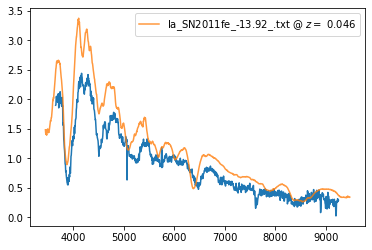

In [17]:
x , y = np.loadtxt(spectrum, usecols = (0,1) ,unpack= True )

scale = y[np.argmin(abs(x-6000))]
y = y / scale

#score_and_index = list(zip(list(sorted(zip(scores,indices), reverse=True))))
#print (score_and_index[:5])

for i, spec in enumerate(all_specs):
    if i <15: 
        plt.plot(x, y)
    
        x_, y_ = np.loadtxt(ref_location + spec, unpack = True)
    
        x_ = x_ * (1 + zs[i])
    
        scale = y_[np.argmin(abs(x_ - 6000))]
        y_ = y_ / scale
    
        plt.plot(x_, y_, label = f'{spec} @ $z=$ {zs[i]}', alpha = 0.8)

        plt.legend()
        plt.show()
    else:
        break
    

In [251]:
all = split( classlist)

ValueError: not enough values to unpack (expected at least 4, got 1)

In [224]:
all_

NameError: name 'all_' is not defined

In [225]:
typ, sne, *_ = zip(*all_)

dic = {}
for ty in typ:
    dic[ty] =[]
    
for i, ty in enumerate(typ):
    if  sne[i] not in dic.get(ty, []):
        dic[ty].append(sne[i])

NameError: name 'all_' is not defined

In [112]:
dic

NameError: name 'dic' is not defined

In [113]:
from collections import Counter
typs = Counter(typ)
typs

NameError: name 'typ' is not defined